<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [63]:
# Check for GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [64]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.2.1+cu121


'cpu'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

1. Train for more epochs
    allow back propergation and SGD more interations to tune parameters
2. Train with more data
    similar to 1, gives models longer to learn.
3. Train bigger model
    more parameters

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [65]:
# 1. Get data
import requests
import zipfile 
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok = True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("UNZIPPING")
        zip_ref.extractall(image_path)


data/pizza_steak_sushi directory exists.


In [66]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [67]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.


In [68]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi_20_percent/train/pizza/3018077.jpg
Image class: pizza
Image height: 512
Image width: 512


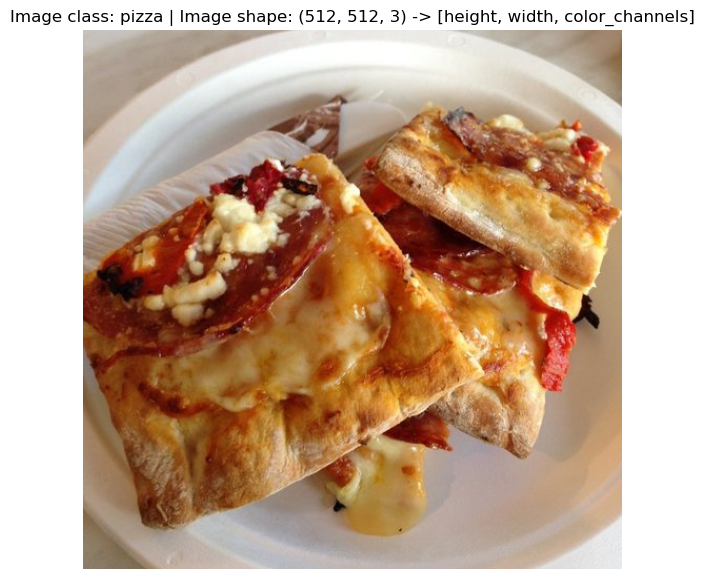

In [107]:
# Visualize an image
import random
from PIL import Image

# Set seed
random.seed(41) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")#


import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);# Do the image visualization with matplotlib



We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [71]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [72]:
# 3.1 Transforming data with torchvision.transforms
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

### Load image data using `ImageFolder`

In [108]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [109]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [111]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [112]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

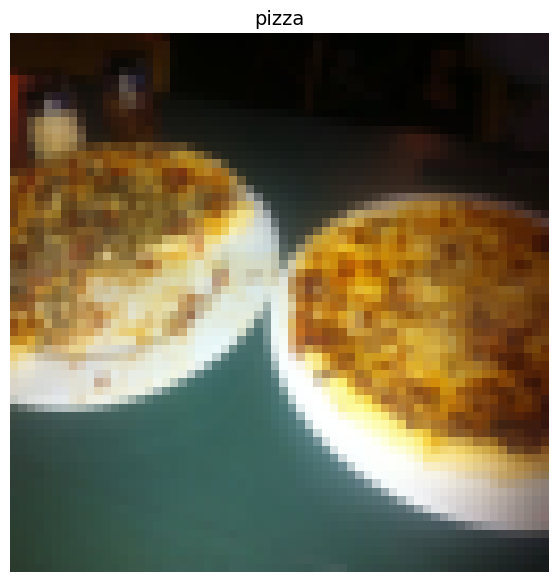

In [113]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [114]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                            batch_size=1,
                            num_workers=1,
                            shuffle=True)#

test_dataloader = DataLoader(dataset=test_data,
                            batch_size=1,
                            num_workers=1,
                            shuffle=False)

train_dataloader, test_dataloader

img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


In [115]:
# How many batches of images are in our data loaders?
# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 8 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7de8879451d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7de8846811d0>)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [116]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [120]:
img_batch, label_batch = next(iter(train_dataloader))
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0706, 0.0640, 0.0410]])

Output prediction probabilities:
tensor([[0.3373, 0.3351, 0.3275]])

Output prediction label:
tensor([0])

Actual label:
1


In [84]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size 

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## 4. Create training and testing functions for `model_0`.

In [90]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X,y) in enumerate(dataloader):
    # Send data to target device

    # 1. Forward pass
    y_pred = model(X)
    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad 
    optimizer.zero_grad()

    # 4. Loss backward 
    loss.backward()
    # train_dataloader
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and average accuracy per batch
  # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [86]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X,y) in enumerate(dataloader):
    
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()
      
      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    
  # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [91]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [ ]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.01)

results = train(model_0,
          train_dataloader_simple,
          test_dataloader_simple,
          optimizer,
          loss_fn,
          50)

print(results["test_acc"])

In [ ]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(#TODO, 
                             lr=0.001)

In [ ]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(#TODO, 
                             lr=0.001)

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [93]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=20, 
                  output_shape=len(train_data.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5120, out_features=3, bias=True)
  )
)

In [94]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), 
                             lr=0.001)

results = train(model_1,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn,
          20)

print(results["test_acc"])

  5%|▌         | 1/20 [00:00<00:09,  2.03it/s]

Epoch: 1 | train_loss: 0.0050 | train_acc: 0.0000 | test_loss: 1.0906 | test_acc: 0.4133


 10%|█         | 2/20 [00:00<00:08,  2.24it/s]

Epoch: 2 | train_loss: 0.0052 | train_acc: 0.0000 | test_loss: 1.0862 | test_acc: 0.4133


 15%|█▌        | 3/20 [00:01<00:07,  2.25it/s]

Epoch: 3 | train_loss: 0.0044 | train_acc: 0.0044 | test_loss: 1.0812 | test_acc: 0.4133


 20%|██        | 4/20 [00:01<00:06,  2.34it/s]

Epoch: 4 | train_loss: 0.0049 | train_acc: 0.0000 | test_loss: 1.0792 | test_acc: 0.4133


 25%|██▌       | 5/20 [00:02<00:06,  2.33it/s]

Epoch: 5 | train_loss: 0.0041 | train_acc: 0.0044 | test_loss: 1.0793 | test_acc: 0.4133


 30%|███       | 6/20 [00:02<00:05,  2.34it/s]

Epoch: 6 | train_loss: 0.0038 | train_acc: 0.0044 | test_loss: 1.0866 | test_acc: 0.4133


 35%|███▌      | 7/20 [00:02<00:05,  2.41it/s]

Epoch: 7 | train_loss: 0.0035 | train_acc: 0.0044 | test_loss: 1.1112 | test_acc: 0.4133


 40%|████      | 8/20 [00:03<00:05,  2.34it/s]

Epoch: 8 | train_loss: 0.0030 | train_acc: 0.0044 | test_loss: 1.1761 | test_acc: 0.4133


 45%|████▌     | 9/20 [00:03<00:04,  2.32it/s]

Epoch: 9 | train_loss: 0.0056 | train_acc: 0.0000 | test_loss: 1.2196 | test_acc: 0.4133


 50%|█████     | 10/20 [00:04<00:04,  2.37it/s]

Epoch: 10 | train_loss: 0.0054 | train_acc: 0.0000 | test_loss: 1.2361 | test_acc: 0.4133


 55%|█████▌    | 11/20 [00:04<00:03,  2.33it/s]

Epoch: 11 | train_loss: 0.0021 | train_acc: 0.0044 | test_loss: 1.2833 | test_acc: 0.4133


 60%|██████    | 12/20 [00:05<00:03,  2.11it/s]

Epoch: 12 | train_loss: 0.0052 | train_acc: 0.0000 | test_loss: 1.3038 | test_acc: 0.4133


 65%|██████▌   | 13/20 [00:05<00:03,  2.17it/s]

Epoch: 13 | train_loss: 0.0049 | train_acc: 0.0000 | test_loss: 1.3048 | test_acc: 0.4133


 70%|███████   | 14/20 [00:06<00:02,  2.25it/s]

Epoch: 14 | train_loss: 0.0024 | train_acc: 0.0044 | test_loss: 1.3285 | test_acc: 0.4133


 75%|███████▌  | 15/20 [00:06<00:02,  2.31it/s]

Epoch: 15 | train_loss: 0.0042 | train_acc: 0.0000 | test_loss: 1.3487 | test_acc: 0.4133


 80%|████████  | 16/20 [00:06<00:01,  2.30it/s]

Epoch: 16 | train_loss: 0.0128 | train_acc: 0.0000 | test_loss: 1.2993 | test_acc: 0.4133


 85%|████████▌ | 17/20 [00:07<00:01,  2.35it/s]

Epoch: 17 | train_loss: 0.0134 | train_acc: 0.0000 | test_loss: 1.2353 | test_acc: 0.4133


 90%|█████████ | 18/20 [00:07<00:00,  2.38it/s]

Epoch: 18 | train_loss: 0.0116 | train_acc: 0.0000 | test_loss: 1.1807 | test_acc: 0.3733


 95%|█████████▌| 19/20 [00:08<00:00,  2.42it/s]

Epoch: 19 | train_loss: 0.0099 | train_acc: 0.0000 | test_loss: 1.1426 | test_acc: 0.3333


100%|██████████| 20/20 [00:08<00:00,  2.33it/s]

Epoch: 20 | train_loss: 0.0037 | train_acc: 0.0044 | test_loss: 1.1226 | test_acc: 0.3333
[0.41333333333333333, 0.41333333333333333, 0.41333333333333333, 0.41333333333333333, 0.41333333333333333, 0.41333333333333333, 0.41333333333333333, 0.41333333333333333, 0.41333333333333333, 0.41333333333333333, 0.41333333333333333, 0.41333333333333333, 0.41333333333333333, 0.41333333333333333, 0.41333333333333333, 0.41333333333333333, 0.41333333333333333, 0.37333333333333335, 0.3333333333333333, 0.3333333333333333]


It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [95]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [96]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.


Excellent, we now have double the training and testing images... 

In [97]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [99]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),                                     
  transforms.ToTensor()
])

# Create datasets
train_data_20 = datasets.ImageFolder(root=train_data_20_percent_path,
                                  transform=data_transform,
                                  target_transform=None)

test_data_20 = datasets.ImageFolder(root=test_data_20_percent_path, 
                                 transform=data_transform)

# Create dataloaders
train_dataloader_20 = DataLoader(dataset=train_data,
                            batch_size=1,
                            num_workers=1,
                            shuffle=True)#

test_dataloader_20 = DataLoader(dataset=test_data,
                            batch_size=1,
                            num_workers=1,
                            shuffle=False)

In [101]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=20, 
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), 
                             lr=0.01)

results = train(model_2,train_dataloader_20,test_dataloader_20,optimizer,loss_fn,20)

print(results["test_acc"])

  5%|▌         | 1/20 [00:00<00:08,  2.33it/s]

Epoch: 1 | train_loss: 0.0050 | train_acc: 0.0000 | test_loss: 1.7327 | test_acc: 0.4133


 10%|█         | 2/20 [00:00<00:07,  2.45it/s]

Epoch: 2 | train_loss: 0.0125 | train_acc: 0.0000 | test_loss: 1.2247 | test_acc: 0.4133


 15%|█▌        | 3/20 [00:01<00:06,  2.46it/s]

Epoch: 3 | train_loss: 0.0094 | train_acc: 0.0000 | test_loss: 1.1318 | test_acc: 0.4133


 20%|██        | 4/20 [00:01<00:06,  2.53it/s]

Epoch: 4 | train_loss: 0.0068 | train_acc: 0.0000 | test_loss: 1.1057 | test_acc: 0.2533


 25%|██▌       | 5/20 [00:02<00:06,  2.49it/s]

Epoch: 5 | train_loss: 0.0046 | train_acc: 0.0044 | test_loss: 1.1145 | test_acc: 0.2533


 30%|███       | 6/20 [00:02<00:05,  2.53it/s]

Epoch: 6 | train_loss: 0.0052 | train_acc: 0.0000 | test_loss: 1.1067 | test_acc: 0.2533


 35%|███▌      | 7/20 [00:02<00:05,  2.49it/s]

Epoch: 7 | train_loss: 0.0050 | train_acc: 0.0000 | test_loss: 1.1021 | test_acc: 0.3467


 40%|████      | 8/20 [00:03<00:04,  2.52it/s]

Epoch: 8 | train_loss: 0.0046 | train_acc: 0.0000 | test_loss: 1.1501 | test_acc: 0.4133


 45%|████▌     | 9/20 [00:03<00:04,  2.50it/s]

Epoch: 9 | train_loss: 0.0047 | train_acc: 0.0000 | test_loss: 1.3746 | test_acc: 0.4533


 50%|█████     | 10/20 [00:03<00:03,  2.52it/s]

Epoch: 10 | train_loss: 0.0129 | train_acc: 0.0000 | test_loss: 1.1276 | test_acc: 0.4667


 55%|█████▌    | 11/20 [00:04<00:03,  2.43it/s]

Epoch: 11 | train_loss: 0.0044 | train_acc: 0.0000 | test_loss: 1.0950 | test_acc: 0.4000


 60%|██████    | 12/20 [00:04<00:03,  2.45it/s]

Epoch: 12 | train_loss: 0.0056 | train_acc: 0.0000 | test_loss: 1.0991 | test_acc: 0.2533


 65%|██████▌   | 13/20 [00:05<00:02,  2.47it/s]

Epoch: 13 | train_loss: 0.0049 | train_acc: 0.0000 | test_loss: 1.0993 | test_acc: 0.3333


 70%|███████   | 14/20 [00:05<00:02,  2.44it/s]

Epoch: 14 | train_loss: 0.0049 | train_acc: 0.0000 | test_loss: 1.0992 | test_acc: 0.3333


 75%|███████▌  | 15/20 [00:06<00:01,  2.51it/s]

Epoch: 15 | train_loss: 0.0049 | train_acc: 0.0000 | test_loss: 1.0991 | test_acc: 0.3333


 80%|████████  | 16/20 [00:06<00:01,  2.46it/s]

Epoch: 16 | train_loss: 0.0049 | train_acc: 0.0000 | test_loss: 1.0985 | test_acc: 0.3333


 85%|████████▌ | 17/20 [00:06<00:01,  2.33it/s]

Epoch: 17 | train_loss: 0.0049 | train_acc: 0.0000 | test_loss: 1.0984 | test_acc: 0.3333


 90%|█████████ | 18/20 [00:07<00:00,  2.20it/s]

Epoch: 18 | train_loss: 0.0049 | train_acc: 0.0000 | test_loss: 1.0980 | test_acc: 0.3333


 95%|█████████▌| 19/20 [00:07<00:00,  2.24it/s]

Epoch: 19 | train_loss: 0.0048 | train_acc: 0.0044 | test_loss: 1.0977 | test_acc: 0.3333


100%|██████████| 20/20 [00:08<00:00,  2.41it/s]

Epoch: 20 | train_loss: 0.0048 | train_acc: 0.0044 | test_loss: 1.0975 | test_acc: 0.3333
[0.41333333333333333, 0.41333333333333333, 0.41333333333333333, 0.25333333333333335, 0.25333333333333335, 0.25333333333333335, 0.3466666666666667, 0.41333333333333333, 0.4533333333333333, 0.4666666666666667, 0.4, 0.25333333333333335, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?